# Финальный проект

### Задание 1. A/B-тестирование

In [23]:
# импортируем нужные библиотеки

import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns


In [2]:
# читаем наши данные

groups = pd.read_csv('Проект_2_groups.csv', sep=';')
groups_add = pd.read_csv('Проект_2_group_add.csv')
active_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

### Предобработка данных:

In [3]:
groups = groups.rename(columns={groups.columns[0]: 'student_id', groups.columns[1]: 'group'})
groups.head()

,student_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# заметим, что группы очень несбалансированы. Это надо будет учитывать при интерпретации

groups.groupby('group').agg({'student_id': 'count'})

,student_id
group,
A,14671
B,59813


In [5]:
groups_add = groups_add.rename(columns={groups_add.columns[0]: 'student_id', groups_add.columns[1]: 'group'})
groups_add.head()

,student_id,group
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
groups_add.groupby('group').agg({'student_id': 'count'})

,student_id
group,
A,22
B,70


In [7]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
checks = checks.rename(columns={checks.columns[1]: 'revenue'})
checks.head()

,student_id,revenue
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### Агрегация по пользователям

In [9]:
checks_agg = checks.groupby('student_id').agg(revenue=('revenue','sum'), orders=('revenue','count')).reset_index()
active_studs_agg = active_studs.groupby('student_id').agg(active_days=('student_id','count')).reset_index()

In [10]:
df = groups.merge(checks_agg, on='student_id', how='left') \
.merge(groups_add, on='student_id', how='left').merge(active_studs_agg, on='student_id', how='left')

In [11]:
# собираем датафрейм со всеми показателями

df = df.fillna({'orders':0, 'revenue':0.0, 'active_days':0})
df = df.drop('group_y', axis=1)
df = df.rename(columns={'group_x': 'group'})
df.head()

,student_id,group,revenue,orders,active_days
0,1489,B,0.0,0.0,0.0
1,1627,A,990.0,1.0,1.0
2,1768,B,0.0,0.0,0.0
3,1783,B,0.0,0.0,0.0
4,1794,A,0.0,0.0,0.0


### Анализируем метрики по группам

Какие метрики я смотрел и почему:

1. Conversion (конверсия в покупку). Ключ к пониманию, влияет ли новая механика на долю пользователей, которые покупают.
2. ARPU (average revenue per user). Учитывает объём покупателей и их платежи. Показывает влияния на доход на пользователя.
3. AOV (average order value). Показывает, если изменения влияют на средний чек покупателей.

In [12]:
metrics = df.groupby('group').agg(
    users_count=('student_id','count'),
    buyers=('orders', 'sum'),
    orders=('orders','sum'),
    revenue=('revenue','sum')
).reset_index() 

In [13]:
metrics['conversion'] = metrics['buyers'] / metrics['users_count']
metrics['arpu'] = metrics['revenue'] / metrics['users_count']
metrics['aov'] = metrics['revenue'] / metrics['buyers']

In [14]:
metrics

,group,users_count,buyers,orders,revenue,conversion,arpu,aov
0,A,14671,107.0,107.0,92096.0000,0.007293,6.277418,860.710280
1,B,59813,433.0,433.0,479330.0036,0.007239,8.013810,1106.997699


In [15]:
# делим пользователей на контрольную и тестовую группу для расчета метрик

groupA = df[df['group']=='A']
groupB = df[df['group']=='B']

In [16]:
# конверсия

conv_a = (groupA['orders']>0).sum()
conv_b = (groupB['orders']>0).sum()
n_a = groupA.shape[0]
n_b = groupB.shape[0]

In [17]:
# проводим z-test для проверки гипотезы о статистической разницы в конверсии

z_stat, pval = proportions_ztest([conv_b, conv_a], [n_b, n_a])

In [18]:
# для метрики ARPU я решил воспользоваться методом bootstrap

def bootstrap_diff_mean(x, y, n_boot=5000, seed=42):
    rng = np.random.RandomState(seed)
    diffs = []
    for _ in range(n_boot):
        xs = rng.choice(x, len(x), replace=True)
        ys = rng.choice(y, len(y), replace=True)
        diffs.append(ys.mean() - xs.mean())
    return np.percentile(diffs, [2.5,97.5]), np.mean(diffs)

ci, diff_mean = bootstrap_diff_mean(groupA['revenue'], groupB['revenue'])

In [19]:
# считаем AOV среди покупателей и используем критерий Манна-Уитни

buyers_a = groupA[groupA['orders']>0]['revenue']
buyers_b = groupB[groupB['orders']>0]['revenue']

u_stat, p_u = stats.mannwhitneyu(buyers_b, buyers_a, alternative='two-sided')

In [20]:
# выоводим значения метрик

print(f"Conversion A: {conv_a/n_a:.4f}, B: {conv_b/n_b:.4f}, p-value={pval:.4f}")
print(f"ARPU diff (B-A): mean={diff_mean:.2f}, 95% CI={ci}")
print(f"AOV p-value={p_u:.6f}, mean A={buyers_a.mean():.2f}, B={buyers_b.mean():.2f}")

Conversion A: 0.0073, B: 0.0072, p-value=0.9448
ARPU diff (B-A): mean=1.74, 95% CI=[-0.18253296  3.55200041]
AOV p-value=0.000210, mean A=860.71, B=1107.00


/var/folders/gv/w8lzwcsd0_d7rgz4964mrrqr0000gn/T/ipykernel_31915/1991996764.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([groupA['revenue'], groupB['revenue']], labels=['A','B'])


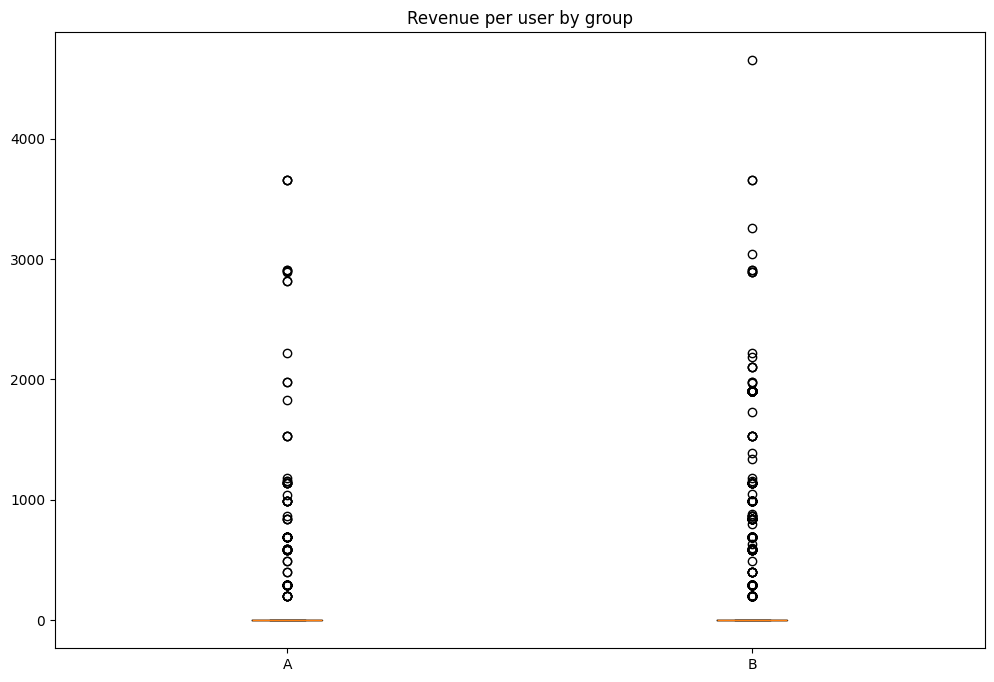

In [21]:
# визуализируем распределения

plt.figure(figsize=(12,8))
plt.boxplot([groupA['revenue'], groupB['revenue']], labels=['A','B'])
plt.title('Revenue per user by group')
plt.show()

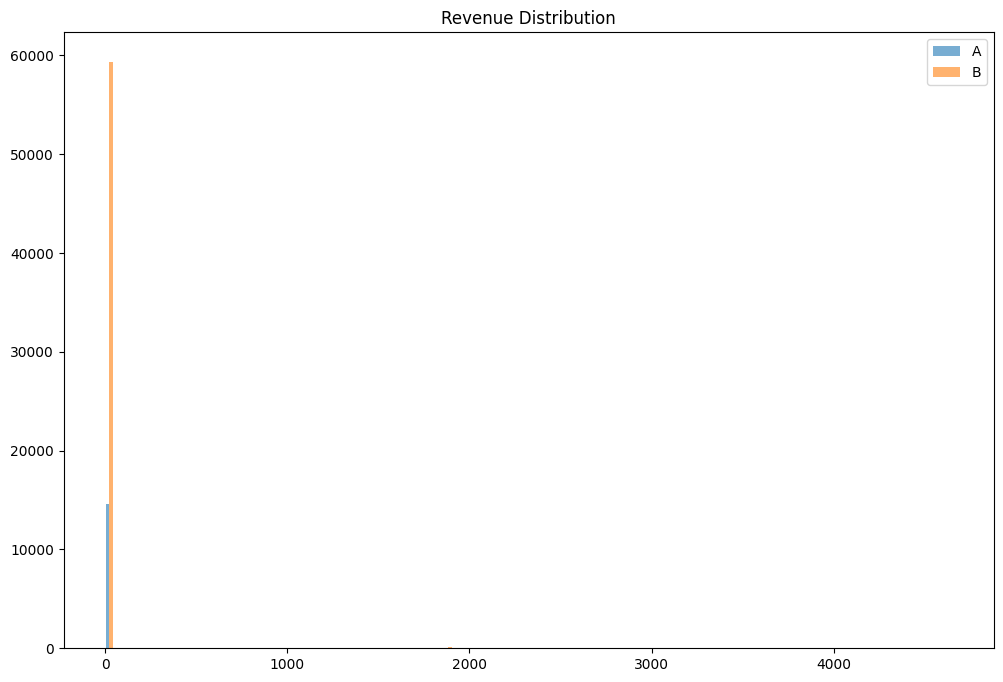

In [25]:
plt.figure(figsize=(12,8))
plt.hist([groupA['revenue'], groupB['revenue']], bins=100, label=['A','B'], alpha=0.6)
plt.legend()
plt.title('Revenue Distribution')
plt.show()

## Выводы по результатам анализа:

1. Конверсия практически не изменилась. Различия оказались статистически незначимыми. P-value равен примерно 0,94. Можно сделать вывод, что новая механика не привела к увеличению доли покупателей.

2. ARPU вырос, но совершенно незначительно. 95% доверительный интервал включает 0. Общий доход на пользователя отличается мало и не проходит стандартный тест на значимость.

3. AOV среди покупателей растет статистически значимо. P-value равен примерно 0,0002. Новая механика, видимо, способствует увеличению среднего чека тех пользователей, которые уже платят. 

4. Новая механика не увеличивает конверсию, но повышает средний чек у тех, кто уже покупает. Возможно, новая механика оплаты делает оплату более удобной или стимулирует лояльных клиентов тратить больше.

#### Рекомендации:

Я считаю, что запускать новую механику оплаты услуг на сайте на всех пользователей пока что не стоит. Следует провести дополнительное сегментное тестирование.

Например, рассмотреть запуск новой механики по сегментам, где рост AOV даёт наибольший профит. 

Можно провести дополнительные типы анализа: когортный анализ, распределение по дням, сравнение retention. 

#### Что нужно делать в первую очередь:

1. Провести целевой роллаут для определенных сегментов (либо провести еще один A/B тест, но с выровненными выборками в группах).

2. Разобраться с выбросами и источниками роста AOV.

3. При подтверждении эффекта в целевых сегментах - масштабировать.